## Training Neural Networks: Backpropagation and SGD

Neural networks have _a lot_ of parameters. Every layer introduces $d_j\cdot d_{j+1}$ parameters for the weight matrix and $d_{j+1}$ parameters for the bias term. The composition of affine functions and nonlinear activations make it impossible to compute the optimum analytically, or to compute the optimum subject to one weight, fixing all the others (the gradients of the nonlinear activations have no inverse function, which is needed to solve the equations given by FONC). The optimization method is crucial for the performance of the neural network and as a result there exist various optimizers that have been applied and developed for neural networks. Typically, neural networks are optimized with a version of gradient descent with momentum. We will discuss the most popular and not too complicated version of gradient descent that is applied in the context of neural networks, called stochastic gradient descent. But first, we discuss how to get the gradient of neural networks. 

### Backpropagation
We consider the optimization of our loss function
\begin{align*}
\mathcal{L}(\mathcal{D},\theta) &= \frac{1}{n} \sum_{i=1}^n CE(y_i,f_\theta(\vvec{x}_i))\\
&= -\frac{1}{n} \sum_{i=1}^n \log(f_\theta(\vvec{x}_i)_{y_i}),
\end{align*}
where
\begin{align*}
f_\theta(\vvec{x}_i) & = \softmax(W\vvec{h}^{(L)}+\vvec{b}),
\end{align*}
and the hidden layers are recursively defined 
\begin{align*}
\vvec{h}^{(\ell)} = \phi_{\ell}(W^{(\ell)}\vvec{h}^{(\ell-1)}+\vvec{b}^{(\ell)}).
\end{align*}
The layer-wise definition of a neural network is helpful to compute the gradient of the loss with the chain rule. This motivates the so-called **backpropagation algorithm** that is in essence an efficiently implementation of the chain rule. Let's have a look how we would apply the chain rule to the loss function above. First, we notice that the gradient subject to $\theta$ gathers all partial derivatives subject to all parameters, that is
\begin{align*}
\nabla_\theta \mathcal{L}(\mathcal{D},\theta) = \begin{pmatrix}\frac{\partial}{\partial W_{11}}\mathcal{L}(\mathcal{D},\theta)\\
\vdots \\
\frac{\partial}{\partial W_{cd_L}}\mathcal{L}(\mathcal{D},\theta)\\
\frac{\partial}{\partial b_1}\mathcal{L}(\mathcal{D},\theta)\\
\vdots\\
\frac{\partial}{\partial b_c}\mathcal{L}(\mathcal{D},\theta)\\
\frac{\partial}{\partial W^{(L)}_{11}}\mathcal{L}(\mathcal{D},\theta)\\
\vdots\\
\frac{\partial}{\partial b^{(1)}_{d_1}}\mathcal{L}(\mathcal{D},\theta)\\
\end{pmatrix}.
\end{align*}
Let's have a look how we can determine partial derivative subject to weight matrix entry $W^{(\ell)}_{kj}$.
\begin{align*}
\frac{\partial}{\partial W^{(\ell)}_{kj}}\mathcal{L}(\mathcal{D},\theta) & = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial W^{(\ell)}_{kj}} CE(y_i,f_\theta(\vvec{x}_i))
\end{align*}
We have a look at the Jacobian of the cross entropy with the chain rule
\begin{align*}
&\frac{\partial}{\partial W^{(\ell)}_{kj}} CE(y_i,f_\theta(\vvec{x}_i))\\ 
&=  \frac{\partial CE(y_i,f_\theta(\vvec{x}_i))}{\partial h^{(L)}}  \frac{\partial h^{(L)}}{\partial W^{(\ell)}_{kj}}\\
&=  \frac{\partial CE(y_i,f_\theta(\vvec{x}_i))}{\partial h^{(L)}}  \frac{\partial \phi_l(W^{(L)}h^{(L-1)}+\vvec{b}^{(L)})}{\partial W^{(\ell)}_{kj}}\\
&=  \frac{\partial CE(y_i,f_\theta(\vvec{x}_i))}{\partial h^{(L)}}  \frac{\partial \phi_L(W^{(L)}h^{(L-1)}+\vvec{b}^{(L)})}{\partial W^{(L)}h^{(L-1)}+\vvec{b}^{(L)}}\frac{\partial W^{(L)}h^{(L-1)}+\vvec{b}^{(L)}}{\partial W^{(\ell)}_{kj}}\\
&=\ldots\\
&=  \frac{\partial CE(y_i,f_\theta(\vvec{x}_i))}{\partial h^{(L)}}  \frac{\partial \phi_L(W^{(L)}h^{(L-1)}+\vvec{b}^{(L)})}{\partial W^{(L)}h^{(L-1)}+\vvec{b}^{(L)}}\frac{\partial W^{(L)}h^{(L-1)}+\vvec{b}^{(L)}}{\partial \vvec{h}^{(L-1)}}\cdot\ldots\cdot \frac{\partial W^{(\ell)}h^{(\ell-1)}+\vvec{b}^{(\ell)}}{\partial W^{(\ell)}_{kj}}.
\end{align*}
We can see how the gradient multiplies the Jacobians of each activation and the affine function of each layer. Hence, if we know the derivatives of the activations, then we can compute the Jacobian. We also observe how we go from the output layer of the network to the front of the network where the weight $W^{(\ell)}_{kj}$ is. This is why it's called backpropagation, we propagate backwards the partial derivatives (Jacobians) of the layers and multiply them.
#### Derivative of the Cross Entropy Loss
```{prf:lemma}
The partial derivatives of the cross-entropy function, applied to a function $f(\vvec{h})=\softmax(W\vvec{h}+\vvec{b})$ that returns the softmax of an affine function 
$$CE(y,f(\vvec{h})) = -\log(\softmax(W\vvec{h}+\vvec{b})_y)$$
are given by 
$$\frac{\partial CE(y,f(\vvec{x}))}{\partial h_j} = \begin{cases}f(\vvec{h})_j -1 & \text{ if }j=y\\f(\vvec{h})_j & \text{ otherwise}\end{cases}$$
```
#### Derivatives of Affine Functions
We already know the Jacobian of the affine functions subject to the hidden layer outputs (see the Optimization exercises):
$$\frac{\partial W\vvec{h} +\vvec{b}}{\partial \vvec{h} } = W^\top$$
Based on this insight, we can derive the Jacobian of the affine function subject to the bias vector:
$$\frac{\partial W\vvec{h} +\vvec{b}}{\partial \vvec{b} } = I.$$
Likewise, we can derive the Jacobian of the affine function subject to a weight matrix entry $W_{kj}$:
$$\frac{\partial W\vvec{h} +b_k}{\partial W_{kj}} = h_j$$
#### Derivatives of Activations
```{prf:lemma}
The (sub-)derivative of the $ReLU(x)=\max{x,0}$ function is
$$ReLU'(x) = \begin{cases}1& \text{ if }x>0\\
[0,1]& \text{ if }x=0\\
0& \text{ if }x<0\end{cases}.$$
```
```{note} 
Although the derivative of ReLU does not exist strictly speaking, practical implementations gloss over this fact and set
$$ReLU'(x) = \begin{cases}1& \text{ if }x>0\\
0& \text{ if }x\leq 0\end{cases}.$$
In practice, this doesn't affect performance and it makes the computation of gradients consistent. 
```
Correspondingly, we obtain as the Jacobian of the element-wise applied activation function a diagonal matrix (see {ref}`jacob_element_wise_func`) 
```{prf:corollary}
The Jacobian of the ReLU activation subject to a vector $\vvec{x}\in\mathbb{R}^d$ is given as
$$\frac{\partial ReLU(\vvec{x})}{\partial\vvec{x}}=\diag(ReLU'(x_1),\ldots,ReLU'(x_d))$$
```
### SGD

We have now discussed how to derive the gradient of the cross-entropy loss, that we can use to optimize the weights of a neural network by gradient descent. The only problem is that neural networks typically require (comparably) vast amounts of data to learn a suitable feature transformation that is able to discriminate between the classes. The computation of the gradient, which requires to add the gradients of the cross-entropy for each data point is typically too costly if the dataset is big.

**Stochastic Gradient Descent (SGD)** offers here a solution by updating the weights using only a small batch of training examples at a time. That is, in every update step, SGD performs a gradient descent step on the loss function
$$\mathcal{L}(\mathcal{B},\theta)\frac{1}{\lvert\mathcal{B}\rvert} \sum_{(\vvec{x},y)\in\mathcal{B}} CE(y,f_\theta(\vvec{x})),$$
where $\mathcal{B}\subseteq \mathcal{D}$ is a **batch**. Typically, the batches are chosen as disjunctive subsets of the dataset: $\mathcal{B}_1\cup\ldots\cup\mathcal{B}_m=\mathcal{D}$ and $\mathcal{B}_b\cap \mathcal{B}_j =\emptyset$. Performing the updates on all batches of this disjunctive decomposition is then called an **epoch**.

```{prf:algorithm} SGD

**Input**: training data $\mathcal{D}$, network $f_\theta$, step-size $\eta$
1. Initialize weights $\theta$ randomly
2. **for** epoch $t\in\{1,\ldots,t_{max}\}$
    1. Divide the data into mini-batches $\mathcal{B}_1\cup\ldots\cup\mathcal{B}_m=\mathcal{D}$
    2. **for** each batch $\mathcal{B}$
        1. $\theta\gets \theta -\eta\nabla \mathcal{L}(\mathcal{B},\theta)$
```
Likewise, we can integrate momentum in this optimization scheme, by performing the updates on a batch only.

#### Properties of SGD
SGD is not only more efficient in its computation of the gradients, it also has many theoretical advantages to gradient descent. The computation of the gradients on batches only introduces noise into the gradient descent updates, that are often useful in navigating complex loss landscapes and escaping local minima. 

{numref}`loss_ladscape_fig` gives an impression of the landscape of a neural network with only two parameters. We see how there are multiple local optima and only one very narrow valley that forms the global optimum. SGD can help in these cases, because it's randomness helps to survey the loss landscape without getting stuck in smaller local minima.  

:::{figure} /images/neuralnets/loss_landscape.png
---
height: 320px
name: loss_ladscape_fig
align: center
---
Loss landscape of neural networks for a bi-dimensional parameter space (borrowed from {cite}`li2017visualizing`). There are several local minima and one global minimum.
:::

However, the randomness of SGD might also be a problem when it comes to the convergence of this method. In fact, SGD requires a decreasing step-size to converge. Hence it requires the application of learning rate schedulers. Additionally, SGD can greatly benefit from additional optimization techniques like momentum.



Loss: 0.906 | Acc: 50.000%
Loss: 0.272 | Acc: 89.125%
Loss: 0.126 | Acc: 95.250%


Loss: 0.076 | Acc: 97.125%
Loss: 0.066 | Acc: 97.125%
Loss: 0.061 | Acc: 97.750%
Loss: 0.059 | Acc: 97.875%


Loss: 0.057 | Acc: 97.875%
Loss: 0.057 | Acc: 97.750%
Loss: 0.056 | Acc: 97.750%


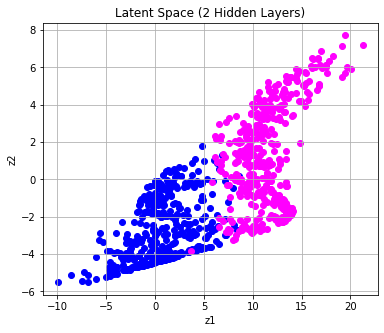

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate and prepare data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Base class with latent layer output
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()

    def get_latent(self, x):
        raise NotImplementedError()

# Two hidden layers: input -> hidden -> 2D latent -> output
class TwoHiddenLayerNet(BaseNet):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 264)
        self.latent = nn.Linear(264, 2)
        self.output = nn.Linear(2, 2)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        z = torch.relu(self.latent(x))
        return self.output(z)

    def get_latent(self, x):
        x = torch.relu(self.hidden(x))
        return self.latent(x)


# Training function
def train_model(model, X, y, epochs=1000, lr=0.01, momentum=0.99):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        if epoch%100==0: #print
            _ , predicted = output.max(1)
            correct = predicted.eq(y).sum().item()
            print('Loss: %.3f | Acc: %.3f%%'% (loss, 100.*correct/y.shape[0]))
        loss.backward()
        optimizer.step()
    return model

# Plot latent space
def plot_latent(model, X, y, title="Latent Space"):
    model.eval()
    with torch.no_grad():
        z = model.get_latent(X).numpy()
    plt.figure(figsize=(6, 5))
    plt.scatter(z[y==0, 0], z[y==0, 1], c='blue')
    plt.scatter(z[y==1, 0], z[y==1, 1], c='magenta')
    plt.title(title)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True)
    plt.show()

# Train and plot
model = train_model(TwoHiddenLayerNet(), X_train_tensor, y_train_tensor)
plot_latent(model, X_train_tensor, y_train_tensor, title="Latent Space (2 Hidden Layers)")
